## Modules

In [13]:
# coding: utf-8

# Import modules

import pandas as pd
import numpy as np
from numpy.random import permutation
import sys
import nltk
import pickle
import time
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as utils
import torchwordemb
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error

from multiprocessing import Pool

sys.path.append('/home/hugoperrin/Bureau/DataScience/Kaggle/ToxicComment/Models/')
from models import *

sys.path.append('/home/hugoperrin/Bureau/DataScience/Kaggle/ToxicComment/Models/')
from utils import *

%matplotlib inline

## Training data

In [2]:
# Import data (1D)
train_vect = np.load('/home/hugoperrin/Bureau/Datasets/ToxicComment/Comment2Vec_train.npy')

# Import data (2D)
# train_vect = np.load('/home/hugoperrin/Bureau/Datasets/ToxicComment/Comment2Vec_train_vM.npy')

time1 = time.time()

# Cross validation loop
CV = 3

CV_score = 0

for i in range(CV):

    print('\n---------------------------------------------------\nLoop number {}'.format(i+1))

    random_order = permutation(len(train_vect))

    ## Train test split
    train_comments = train_vect[random_order[:120000]]
    valid_comments = train_vect[random_order[120001:135000]]
    test_comments = train_vect[random_order[135001:]]

    train_labels = train_vect[random_order[:120000]]
    valid_labels = train_vect[random_order[120001:135000]]
    test_labels = train_vect[random_order[135001:]]

    ## Parameters
    use_GPU = True
    batch_size = 64
    num_epoch = 9

    ## Data to tensor
    train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(train_comments), 
                                                   torch.FloatTensor(train_labels))

    valid_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(valid_comments), 
                                                   torch.FloatTensor(valid_labels))

    test_dataset = torch.FloatTensor(test_comments)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers = 8)

    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=batch_size,
                                               shuffle=False, 
                                               num_workers = 8)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size,
                                               shuffle=False, 
                                               num_workers = 8)
    ## Model 
    net = Autoencoder()

    ## Loss function
    criterion = nn.MSELoss()
    
    ## Optimization algorithm
    optimizer = optim.RMSprop(net.parameters(), lr=0.0003, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9)

    ## Training model
    train_autoencoder(num_epoch, net, train_loader, optimizer, criterion,
                      display_step=1000, valid_loader=valid_loader, use_GPU=use_GPU)

    ## Predicting 
    predictions = pd.DataFrame(predict_autoencoder(net, test_loader, use_GPU=use_GPU))
    
    ## Performance measuring
    score = mean_squared_error(test_labels, predictions)

    CV_score += score*(1/CV)

    print("\nModel intermediate score: %.4f" % (score))


print("\nModel final score: %.4f\n" % (CV_score))


time2 = time.time()
diff_time = (time2 - time1)/60
print("Training time is {} minutes\n".format(round(diff_time,1)))


---------------------------------------------------
Loop number 1

>> Learning: 13312 parameters

Epoch: 1, step:  1000, training MSE: 0.1822, validation MSE: 0.1749
Epoch: 2, step:  2000, training MSE: 0.0192, validation MSE: 0.1655
Epoch: 2, step:  3000, training MSE: 0.1517, validation MSE: 0.1645
Epoch: 3, step:  4000, training MSE: 0.0366, validation MSE: 0.1658
Epoch: 3, step:  5000, training MSE: 0.1494, validation MSE: 0.1579
Epoch: 4, step:  6000, training MSE: 0.0538, validation MSE: 0.1420
Epoch: 4, step:  7000, training MSE: 0.1395, validation MSE: 0.1413
Epoch: 5, step:  8000, training MSE: 0.0686, validation MSE: 0.1374
Epoch: 5, step:  9000, training MSE: 0.1356, validation MSE: 0.1340
Epoch: 6, step: 10000, training MSE: 0.0843, validation MSE: 0.1326
Epoch: 6, step: 11000, training MSE: 0.1333, validation MSE: 0.1297
Epoch: 7, step: 12000, training MSE: 0.0998, validation MSE: 0.1333
Epoch: 7, step: 13000, training MSE: 0.1324, validation MSE: 0.1327
Epoch: 8, step: 1

## Creating final dataset

In [12]:
## Loading target
Xtrain = pd.read_csv('/home/hugoperrin/Bureau/Datasets/ToxicComment/train.csv')
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = Xtrain[list_classes].values

del Xtrain

## Creating 2D embedding
dataset = torch.FloatTensor(train_vect)
           
loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers = 8)

encoded = get_encoded(net, loader, use_GPU=use_GPU)

# Concatenation of encoded data and target
encoded = np.concatenate((encoded, targets), axis=1)

encoded = pd.DataFrame(encoded, columns=['V1', 'V2'] + list_classes)

encoded.head()

,V1,V2,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,-0.092412,-0.311625,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007185,0.079838,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.005198,0.102410,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.076255,-4.526840,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.870801,-2.378546,0.0,0.0,0.0,0.0,0.0,0.0


## Plotting 2D embedding

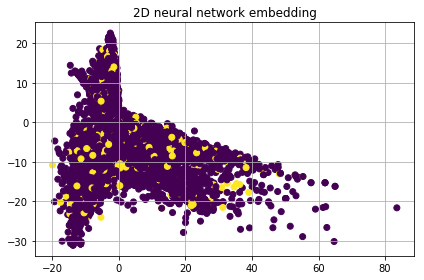

In [16]:
fig, ax = plt.subplots()
ax.scatter(encoded['V1'], encoded['V2'], c=encoded['toxic'])

ax.set_title('2D neural network embedding')

ax.grid(True)
fig.tight_layout()

plt.show()